<a href="https://colab.research.google.com/github/Daegil2/practice/blob/main/word_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import time

In [ ]:
BATCH_SIZE = 1024
EPOCHS = 100

# validation set을 만들어서 사용할지 말지
VALIDATION = False
if VALIDATION:
    VAL_SIZE = .25
    early_stopping = 50
    SEED = 0
else:
    VAL_SIZE = .0
    early_stopping = 0
    SEED = None

LR = 1e-4

# 토치 트랜스폼 적용할지 말지
CROP = True
ROTATION = True
PERSPECTIVE = True
NORMALIZATION = True

# 이미지 (BATCH_SIZE x 28 x 28 x 1) -> (BATCH_SIZE x 28 x 28 x 3)
CONCAT = True

DROPOUT = .25

In [ ]:
#추가 
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
train=pd.read_csv('/content/gdrive/MyDrive/corab/word/train/train_data.csv')
test=pd.read_csv('/content/gdrive/MyDrive/corab/word/test/test_data.csv')


In [ ]:
images=[]

for image_name in train['file_name']:
    image = np.array(Image.open(f'/content/gdrive/MyDrive/corab/word/train/{image_name}'))
    images.append(image)

X = np.expand_dims(np.array(images),-1)
if CONCAT:
    X= np.concatenate([X,X,X],-1)
y= np.array(train['label'])

test_images=[]

for image_name in test['file_name']:
    image = np.array(Image.open(f'/content/gdrive/MyDrive/corab/word/test/{image_name}'))
    test_images.append(image)

X_test= np.expand_dims(np.array(test_images),-1)
if CONCAT:
    X_test = np.concatenate([X_test,X_test,X_test],-1)

print(X.shape, y.shape, X_test.shape)

(5000, 28, 28, 3) (5000,) (5000, 28, 28, 3)


In [ ]:
if VALIDATION:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=VAL_SIZE, random_state=SEED)
else:
    X_train, y_train = X, y


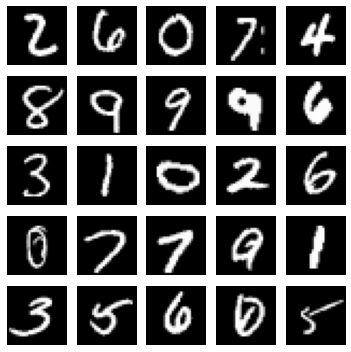

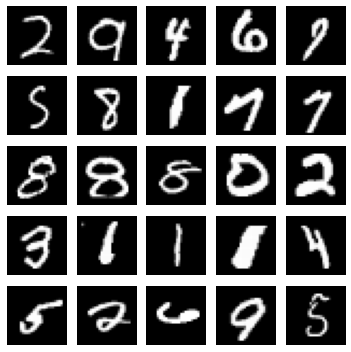

In [ ]:
nrows, ncols = 5,5

indices = np.random.randint(len(X), size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5,5))
for i in range(nrows):
    for j in range(ncols):
        idx = indices[i][j]
        ax[i][j].imshow(X[idx], cmap='gray')
        # ax[i][j].set_title(f"{y[idx]}")
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

indices = np.random.randint(len(X_test), size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5,5))
for i in range(nrows):
    for j in range(ncols):
        idx = indices[i][j]
        ax[i][j].imshow(X_test[idx], cmap='gray')
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models

In [ ]:
def get_transform(train=True):
    t = list()
    t.append(transforms.ToTensor())
    if CROP and train:
        t.append(transforms.RandomResizedCrop(size=28,scale=(.35, 1.),ratio=(.5, 2),interpolation=transforms.InterpolationMode.NEAREST))
    if ROTATION and train:
        t.append(transforms.RandomRotation(
            degrees=25,interpolation=transforms.InterpolationMode.NEAREST))
    if NORMALIZATION:
        t.append(transforms.Normalize(mean=(.5),std=(.5)))
    return transforms.Compose(t)
    

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y=None, transform=None, target_transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        inputs = self.X[idx]
        if transform:
            inputs = self.transform(inputs)
        if self.y is not None:
            labels = self.y[idx]
            if self.target_transform:
                labels = self.target_transform(labels)
            return inputs, labels
        return inputs
    
transform = get_transform()
transform_test = get_transform(train=False)

transformed_train = CustomDataset(X=X_train, y=y_train, transform=transform)
if VALIDATION:
    transformed_valid = CustomDataset(X=X_valid, y=y_valid, transform=transform_test)
transformed_test = CustomDataset(X=X_test, transform=transform_test)

trainloader = DataLoader(transformed_train, batch_size=BATCH_SIZE, shuffle=True)
if VALIDATION:
    validloader = DataLoader(transformed_valid, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(transformed_test, batch_size=BATCH_SIZE, shuffle=False)

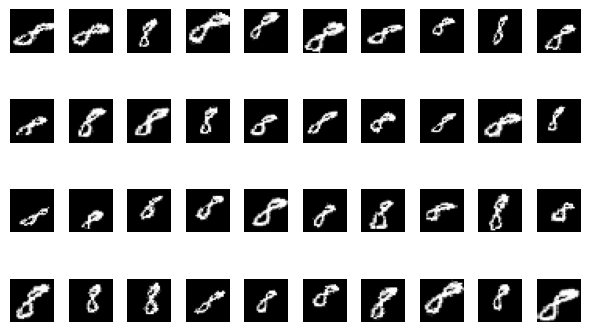

In [ ]:
def get_transform(train=True):
    t = list()
    t.append(transforms.ToTensor())
    if CROP and train:
        t.append(transforms.RandomResizedCrop(size=28,scale=(.65, 1.),ratio=(.75,1+1/3),interpolation=transforms.InterpolationMode.NEAREST))
    if ROTATION and train:
        t.append(transforms.RandomRotation(
            degrees=25,interpolation=transforms.InterpolationMode.NEAREST))
    if PERSPECTIVE and train:
        t.append(transforms.RandomPerspective(distortion_scale=.55,p=.75,interpolation=transforms.InterpolationMode.NEAREST))
    if NORMALIZATION:
        t.append(transforms.Normalize(mean=(.5),std=(.5)))
    return transforms.Compose(t)

ANIMATION = False
transform = get_transform()
idx = np.random.randint(len(X))
if ANIMATION:
    for _ in range(100):
        ipd.clear_output(wait=True)
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(np.squeeze(X[idx]), cmap='gray')
        ax[1].imshow(np.squeeze(transform(X[idx]))[0], cmap='gray')
        ax[0].axis('off')
        ax[1].axis('off')
        plt.show()
else:
    fig, ax = plt.subplots(nrows=4, ncols=10,dpi=100)
    for i in range(4):
        for j in range(10):
            ax[i][j].imshow(np.squeeze(transform(X[idx]))[0], cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        if CONCAT:
            pass
        else:
            self.inputs = nn.Conv2d(1,3,kernel_size=(1,1))
        self.model = models.resnet18(pretrained=False)
        self.drop = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(1000,10)
    def forward(self, x, softmax=True):
        if CONCAT:
            pass
        else:
            x = self.inputs(x)
        x = self.model(x)
        x = self.drop(x)
        x = self.fc(x)
        if softmax:
            x = F.softmax(x)
        return x
    
model = Model()
model.cuda()
model.train()
'DONE'


'DONE'

In [ ]:
min_valid_loss = 1e100
patience = 0

optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

model_filename = f"./weights/model-BS{BATCH_SIZE}-E{EPOCHS}-V{str(VALIDATION)[0]}-VS{VAL_SIZE:.2f}-SD{SEED}-LR{LR}-es{early_stopping}"

for e in range(EPOCHS):
    start_time = time.time()
    learning_loss = list()
    train_acc = list()
    for i, d in enumerate(trainloader, 0):
        inputs, labels = d
        inputs, labels = inputs.cuda(), torch.LongTensor(labels).cuda()
        
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        learning_loss.append(loss.item())
        train_acc.append(
            torch.sum(
                torch.argmax(outputs,-1)==labels
            ).item()/len(outputs))
    learning_loss = np.mean(learning_loss)
    train_acc = np.mean(train_acc)
    
    if VALIDATION:
        
        val_loss = list()
        val_acc = list()
        with torch.no_grad():
            for i, d in enumerate(validloader, 0):
                inputs, labels = d
                inputs, labels = inputs.cuda(), torch.LongTensor(labels).cuda()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item())
                val_acc.append(torch.sum(torch.argmax(outputs,-1)==labels).item()/len(outputs))
        val_loss = np.mean(val_loss)
        val_acc = np.mean(val_acc)
        if val_loss < min_valid_loss:
            min_valid_loss = val_loss
            patience = 0
            torch.save(model.state_dict(), model_filename)
        else:
            patience += 1

        if patience == early_stopping:
            break
        
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}")
    print(f"current train loss={learning_loss:.4f}, acc={train_acc*100:.2f}%")
    if VALIDATION:
        print(f"current val loss={val_loss:.4f}, acc={val_acc*100:.2f}%")
        print(f"patience={patience}")
        print(f"min val loss={min_valid_loss:.4f}")
    print(f"{time.time()-start_time:.2f} sec/epoch")
if VALIDATION:
    model.load_state_dict(torch.load(model_filename))
    model.eval()
    
    val_loss = list()
    val_acc = list()
    with torch.no_grad():
        for i, d in enumerate(validloader, 0):
            inputs, labels = d
            inputs, labels = inputs.cuda(), torch.LongTensor(labels).cuda()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())
            val_acc.append(torch.sum(torch.argmax(outputs,-1)==labels).item()/len(outputs))
    val_loss = np.mean(val_loss)
    val_acc = np.mean(val_acc)
    print(val_acc)
    
print('DONE')

100/100
current train loss=1.5548, acc=90.85%
5.38 sec/epoch
DONE


In [ ]:
y_pred=list()
with torch.no_grad():
    for i, d in enumerate(testloader, 0):
        inputs =d.cuda()
        outputs=model(inputs)
        y_pred.append(torch.argmax(outputs,-1).cpu().numpy())
y_pred =np.concatenate(y_pred, 0)

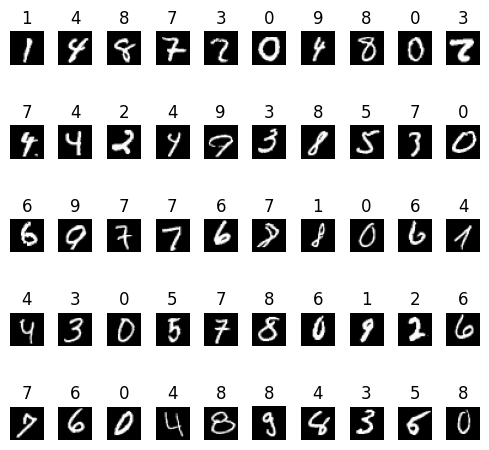

In [ ]:
nrows, ncols = 5, 10

indices = np.random.randint(len(X), size=(nrows, ncols))

indices = np.random.randint(len(X_test), size=(nrows, ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, dpi=100, figsize=(5,5))
for i in range(nrows):
    for j in range(ncols):
        idx = indices[i][j]
        ax[i][j].imshow(X_test[idx], cmap='gray')
        ax[i][j].set_title(f"{y_pred[idx]}")
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
if VALIDATION:
    f = f'./content/gdrive/MyDrive/corab/word/{BATCH_SIZE}-E{EPOCHS}-V{str(VALIDATION)[0]}-VS{VAL_SIZE:.2f}-SD{SEED}-LR{LR}-es{early_stopping}-C{str(CROP)[0]}-R{str(ROTATION)[0]}-P{str(PERSPECTIVE)[0]}-N{str(NORMALIZATION)[0]}-CC{str(CONCAT)[0]}-DR{DROPOUT:.2f}.csv'
else:
    f = f'./content/gdrive/MyDrive/corab/word/{BATCH_SIZE}-E{EPOCHS}-V{str(VALIDATION)[0]}-SD{SEED}-LR{LR}-C{str(CROP)[0]}-R{str(ROTATION)[0]}-P{str(PERSPECTIVE)[0]}-N{str(NORMALIZATION)[0]}-CC{str(CONCAT)[0]}-DR{DROPOUT:.2f}.csv'

In [ ]:
submission=pd.read_csv('/content/gdrive/MyDrive/corab/word/sample_submission.csv')
submission['label']= y_pred


In [ ]:
submission.to_csv('/content/gdrive/MyDrive/corab/word/submission.csv', index=False)

In [ ]:
f

'./content/gdrive/MyDrive/corab/word/1024-E100-VF-SDNone-LR0.0001-CT-RT-PT-NT-CCT-DR0.25.csv'